In [12]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import ndcg_score
from collections import defaultdict
from sklearn.model_selection import train_test_split




In [13]:
# 1) evaluation scenarios and file‐name conventions
scenarios = {
    "standard":   "standard",
    "user":       "user",
    "item":       "item",
}
methods = {
    "ALS":         "als",
    "CBF":         "cbf",
    "KNN":        "knn",
    "Hybrid-I":    "hybrid",
    "Hybrid-U":    "hybrid_userCF",
}
K = 10




In [14]:
def split_per_user(df: pd.DataFrame, test_frac: float = 0.20, seed: int = 7):
    """Return (train_df, test_df) with an 80-20 split for each individual user."""
    train, test = [], []
    for _uid, grp in df.groupby("userId"):
        if len(grp) == 1:
            train.append(grp)
            continue
        tr, te = train_test_split(grp, test_size=test_frac, random_state=seed)
        train.append(tr)
        test.append(te)
    return pd.concat(train), pd.concat(test)

In [15]:
# 2) load test‐splits per scenario
test_dfs = {}
# standard: rebuild same split you used in modeling
ratings = pd.read_csv("../subset_ratings.csv", usecols=["userId","movieId","rating"])
# assume you have a split_per_user function defined in this notebook already:
train_std, test_std = split_per_user(ratings, test_frac=0.2, seed=42)
test_dfs["standard"] = test_std[["userId","movieId","rating"]]

# user/item cold splits
test_dfs["user"] = pd.read_csv("./user_cold_test.csv", usecols=["userId","movieId","rating"])
test_dfs["item"] = pd.read_csv("./item_cold_test.csv", usecols=["userId","movieId","rating"])




In [16]:
# 3) metric functions
def precision_recall_at_k(preds, test_df, K=10):
    hit, rec_cnt, rel_cnt = 0, 0, 0
    for u, grp in test_df.groupby("userId"):
        u = str(u)
        if u not in preds: continue
        true = set(grp.movieId)
        topk = preds[u][:K]
        hit   += len(true & set(topk))
        rec_cnt += K
        rel_cnt += len(true)
    prec = hit/rec_cnt if rec_cnt else 0
    rec  = hit/rel_cnt if rel_cnt else 0
    return prec, rec






In [17]:
import numpy as np
from sklearn.metrics import ndcg_score

def ndcg_at_k(pred_dict, test_df, K=10):
    all_scores = []
    all_truths = []
    for u, grp in test_df.groupby('userId'):
        u = str(u)
        if u not in pred_dict:
            continue

        # get up to K predictions, pad with None so rel‐vector is length K
        preds = pred_dict[u][:K]
        if len(preds) < K:
            preds = preds + [None] * (K - len(preds))

        true_set = set(grp.movieId)
        # build binary relevance vector of length K
        rel = [1 if m in true_set else 0 for m in preds]

        all_scores.append(rel)
        # ideal DCG ordering is just sorted descending
        all_truths.append(sorted(rel, reverse=True))

    if not all_scores:
        return 0.0

    # convert to arrays of shape (n_users, K)
    score_arr = np.array(all_scores)
    truth_arr = np.array(all_truths)

    # now call sklearn’s ndcg_score
    return ndcg_score(truth_arr, score_arr)

In [18]:
# 4) loop and compute
results = []
for scen_key, scen_name in scenarios.items():
    test_df = test_dfs[scen_key]
    for method_name, prefix in methods.items():
        fn = Path("../coldstart_pred")/f"{prefix}_{scen_name}_top{K}.json"
        if not fn.exists():
            print(f"⚠️ missing {fn}, skipping")
            continue
        preds = json.load(open(fn))
        p, r = precision_recall_at_k(preds, test_df, K)
        n    = ndcg_at_k(preds, test_df, K)
        results.append({
            "Scenario": scen_key,
            "Method":   method_name,
            "P@10":     p,
            "R@10":     r,
            "NDCG@10":  n
        })

# 5) build DataFrame and display
df = pd.DataFrame(results)
df = df.pivot(index="Method", columns="Scenario", values=["P@10","R@10","NDCG@10"])
# flatten multi‐index
df.columns = [f"{m}_{s}" for m,s in df.columns]
df = df.loc[methods.keys()]  # ensure your method order
df.style.format("{:.4f}")

,P@10_item,P@10_standard,P@10_user,R@10_item,R@10_standard,R@10_user,NDCG@10_item,NDCG@10_standard,NDCG@10_user
Method,,,,,,,,,
ALS,0.0003,0.0012,0.0125,0.0003,0.0003,0.0005,0.0014,0.0060,0.0871
CBF,0.0000,0.0061,0.1909,0.0000,0.0015,0.0098,0.0001,0.0278,0.4445
KNN,0.0004,0.0041,0.0156,0.0005,0.0010,0.0009,0.0020,0.0177,0.0611
Hybrid-I,0.0004,0.0448,0.1955,0.0005,0.0107,0.0100,0.0016,0.1633,0.4483
Hybrid-U,0.0000,0.0538,0.5182,0.0000,0.0128,0.0266,0.0000,0.1969,0.7422


# Visualization

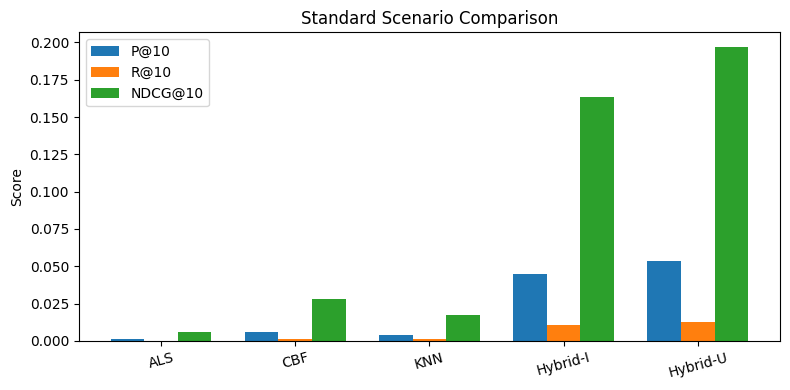

In [19]:
import numpy as np
import matplotlib.pyplot as plt

models = df.index.tolist()                    # ['ALS','KNN','CBF','Hybrid-I','Hybrid-U']
p   = df['P@10_standard'].values
r   = df['R@10_standard'].values
n   = df['NDCG@10_standard'].values

x = np.arange(len(models))
w = 0.25

plt.figure(figsize=(8,4))
plt.bar(x - w, p, w, label='P@10')
plt.bar(x    , r, w, label='R@10')
plt.bar(x + w, n, w, label='NDCG@10')
plt.xticks(x, models, rotation=15)
plt.ylabel('Score')
plt.title('Standard Scenario Comparison')
plt.legend()
plt.tight_layout()
plt.show()


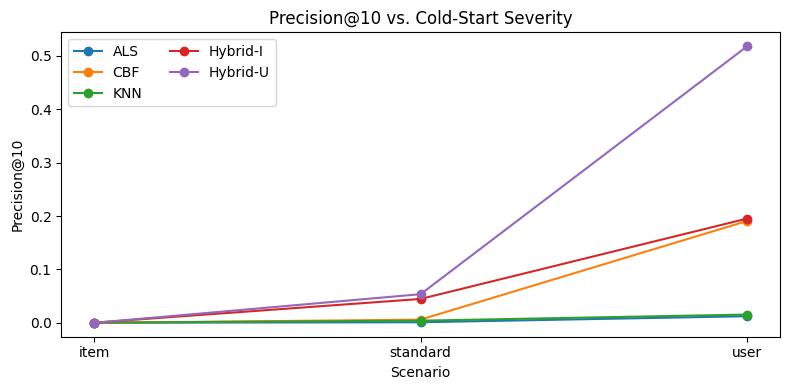

In [20]:
scens = ['item','standard','user']
plt.figure(figsize=(8,4))
for model in models:
    vals = [ df.loc[model, f'P@10_{s}'] for s in scens ]
    plt.plot(scens, vals, marker='o', label=model)

plt.xlabel('Scenario')
plt.ylabel('Precision@10')
plt.title('Precision@10 vs. Cold‐Start Severity')
plt.legend(loc='best', ncol=2)
plt.tight_layout()
plt.show()


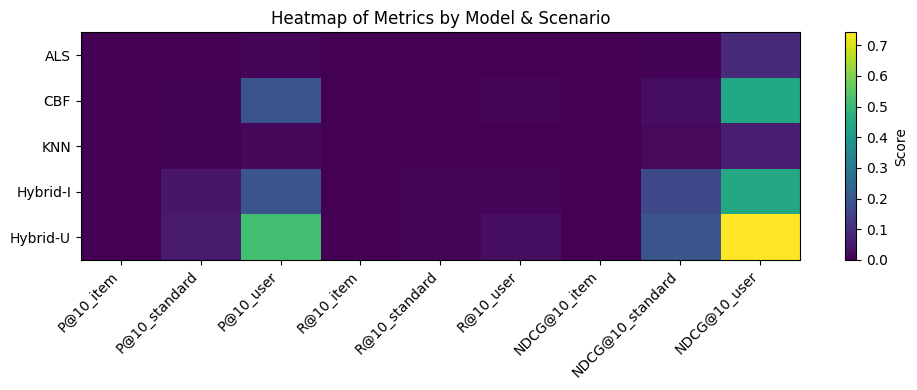

In [21]:
import matplotlib.pyplot as plt

# stack your metrics into one DataFrame of shape (models × (metric,scenario))
hm = df[['P@10_item','P@10_standard','P@10_user',
         'R@10_item','R@10_standard','R@10_user',
         'NDCG@10_item','NDCG@10_standard','NDCG@10_user']]

plt.figure(figsize=(10,4))
plt.imshow(hm, aspect='auto')
plt.yticks(np.arange(len(models)), models)
plt.xticks(np.arange(hm.shape[1]), hm.columns, rotation=45, ha='right')
plt.colorbar(label='Score')
plt.title('Heatmap of Metrics by Model & Scenario')
plt.tight_layout()
plt.show()


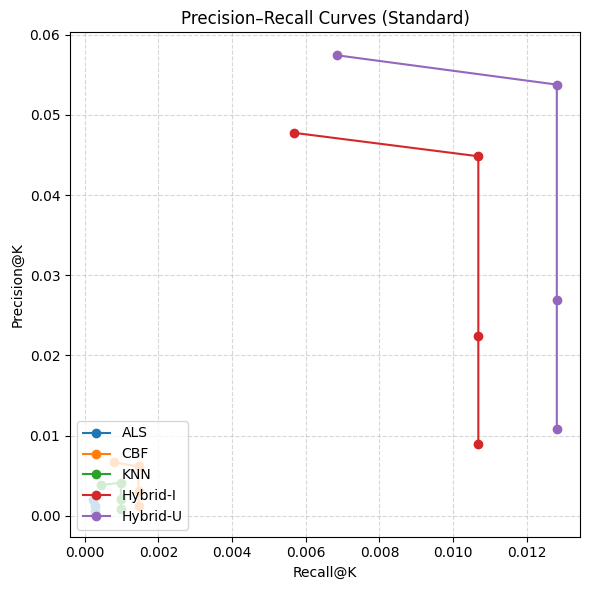

In [22]:
import json
import matplotlib.pyplot as plt

# 1) helper to load saved JSON for any method & scenario
def load_preds(prefix, scenario):
    fn = f"../coldstart_pred/{prefix}_{scenario}_top10.json"
    return json.load(open(fn))

# 2) define your methods & prefixes
methods = {
    'ALS':        'als',
    'CBF':        'cbf',
    'KNN':        'knn',
    'Hybrid-I':   'hybrid',  # or whatever your filename convention is
    'Hybrid-U':   'hybrid_userCF'
}

Ks = [5, 10, 20, 50]
scenario = 'standard'
plt.figure(figsize=(6,6))

for model, prefix in methods.items():
    precs, recs = [], []
    preds_dict  = load_preds(prefix, scenario)
    for k in Ks:
        p, r = precision_recall_at_k(preds_dict, test_dfs[scenario], k)
        precs.append(p)
        recs.append(r)
    plt.plot(recs, precs, marker='o', label=model)

plt.xlabel('Recall@K')
plt.ylabel('Precision@K')
plt.title('Precision–Recall Curves (Standard)')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
